<a href="https://colab.research.google.com/github/Bhargavi1504/reg-class_notebooks/blob/main/reg%2Bclassi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Customer segmentation

🔬 Advanced ML Workflow:
✅ 1. Advanced Feature Engineering
RFM features (Recency, Frequency, Monetary)

Calculate churn probability using survival analysis.

Create features like:

Avg Monthly Revenue

Total Refunds / Revenue

Watch Consistency Score

Days Since Last Complaint

✅ 2. Data Transformation
Outlier treatment (e.g., winsorization, log scaling of CLTV).

Imputation strategies for behavior fields.

Encoding: OneHotEncoder, TargetEncoding, FrequencyEncoding.

✅ 3. Model Selection
Use advanced regressors:

LightGBM / CatBoost Regressor (handles categorical data)

ElasticNetCV

Quantile Regression (for confidence intervals)

Ensemble stacking

✅ 4. Model Explainability
Global: SHAP feature importance, permutation importance.

Local: SHAP force plot for individual customers.

Fairness analysis across gender/region.

✅ 5. Business Evaluation Metrics
RMSE, MAPE (for monetary predictions)

Prediction buckets (0–1K, 1K–5K, 5K+ customers)

ROI of targeted retention campaigns using predicted CLTV

✅ 6. Bonus Tasks
Survival models to model time-to-churn (Cox Regression, Kaplan-Meier).

Train a two-part model:

Part 1: Will the customer churn (classifier)?

Part 2: If not, what’s their CLTV (regressor)?



In [133]:
import numpy as np
import pandas as pd

np.random.seed(42)
n=800

d=pd.DataFrame({
    'Customer_id' : [f'{i:04d}'for i in range(n)],
    'Age' : np.random.randint(18,70,n),
    'Gender' : np.random.choice(['male','female','other'],n),
    'Region': np.random.choice(['North','South','East','West','Central'],n),
    'SubscriptionPlan': np.random.choice(['199','499','799'],n),
    'Tenure': np.random.randint(1,36,n),
    'TotalWatchTime':np.random.normal(loc=100,scale=10,size=n).clip(10),
    'AvgSessionDuration' : np.random.normal(loc=40,scale=10,size=n).clip(10),
    'DeviceType':np.random.choice(['Mobile','Tv','Laptop','Tablet'],n),
    'PaymentType': np.random.choice(['UPI','Credit card','Paypal','Wallet'],n),
    'ReferralSource':np.random.choice(['Ads','Friends','SEO','social-media'],n),
    'IsAutoRenewOn': np.random.choice([1,0],p=[0.68,0.32],size=n),
    'Days-since-last-login' : np.random.randint(1,99,n),
    'ComplaintsRaised': np.random.poisson(0.5,n).clip(0,5),
    'TotalRefunds': np.random.binomial(3,0.1,n)

})


#target variable for regression
def generate_cltv(row):
    base_value = int(row['SubscriptionPlan']) * row['Tenure']
    multiplier = 1 + (row['TotalWatchTime'] / 100) + (0.1 if row['IsAutoRenewOn'] else -0.2)
    penalty = row['ComplaintsRaised'] * 20 + row['TotalRefunds'] * 50
    cltv = base_value * multiplier - penalty
    return max(cltv, 0)


df=pd.DataFrame(d)
d['CLTV']=df.apply(generate_cltv,axis=1).round(2)

#target variable for classification
# Define churn: customers who haven't logged in for over 60 days,
# raised > 2 complaints, or have low CLTV
d['Churn'] = (
    (d['Days-since-last-login'] > 60) |
    (d['ComplaintsRaised'] > 2) |
    (d['CLTV'] < d['CLTV'].quantile(0.25))
).astype(int)


#injecting outliers ans missing
#outliers
d.loc[d.sample(frac=0.01).index,'TotalWatchTime']=d['TotalWatchTime'].mean()*5
idx = d.sample(frac=0.02).index  # select 2% of rows
d.loc[idx, 'AvgSessionDuration'] = np.random.choice([5, 300], size=len(idx))  # generate correct-sized values

d.loc[d.sample(frac=0.02).index,'CLTV']=d['CLTV'].mean()*10
#missing
d.loc[d.sample(frac=0.02).index,'Gender']=np.nan
d.loc[d.sample(frac=0.01).index,'AvgSessionDuration']=np.nan
d.loc[d.sample(frac=0.02).index,'PaymentType']=np.nan

#correlation in target-this happens while defining the func generate_cltv

#injecting noise

noise=np.random.rand(n)<0.05
d['TotalRefunds'] = d['TotalRefunds'].astype(float)  # temporarily make it float
d.loc[noise, 'TotalRefunds'] += np.random.normal(loc=0, scale=1, size=noise.sum())
# Keep TotalRefunds in valid range [0, 5] and round to integer
d['TotalRefunds'] = d['TotalRefunds'].clip(0, 5).round().astype(int)


  Customer_id  Age  Gender   Region SubscriptionPlan  Tenure  TotalWatchTime  \
0        0000   56  female  Central              499      27       91.525703   
1        0001   69  female    North              499      34      105.388062   
2        0002   46  female     East              199      14       99.513931   
3        0003   32   other    South              499       8      104.486131   
4        0004   60    male     East              199      35       96.451926   

   AvgSessionDuration DeviceType PaymentType ReferralSource  IsAutoRenewOn  \
0           35.458314         Tv      Paypal        Friends              1   
1           43.396019         Tv      Paypal            Ads              1   
2           22.512539     Tablet      Paypal            Ads              1   
3          300.000000         Tv         UPI            Ads              1   
4           46.541056     Mobile         UPI        Friends              1   

   Days-since-last-login  ComplaintsRaised  TotalR

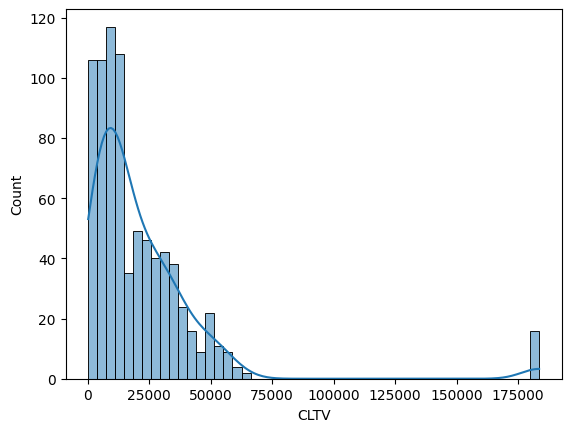

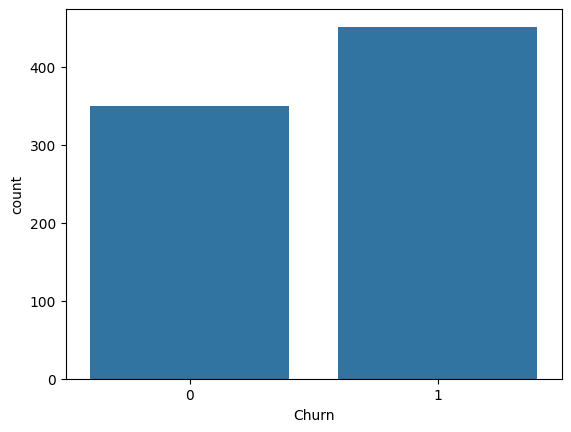

In [134]:
#step-2 data understanding

#dataset overview
print(d.head())
print(d.shape)
print(d.info())

#summary statistics
print(d.select_dtypes(include=['int64','float64']).describe().T)

#cardinality
cat_c=d.select_dtypes(include=['object']).columns.tolist()
if 'Customer_id' in cat_c:
    cat_c.remove('Customer_id')
for i in cat_c:
    print(f'{i} has uniques feature: {d[i].nunique()} and the features are {d[i].unique()}')

#check for duplicates
print(d.duplicated().sum())

#check for missing values
print(d.isnull().sum())

#datatypes
print(d.dtypes)

#class-Imbalance for category
print(d['CLTV'].value_counts())
print(d['Churn'].value_counts())

import seaborn as sns
import matplotlib.pyplot as plt
#distribution of target variable-reg-CLTV
sns.histplot(d['CLTV'], bins=50, kde=True)
plt.show()


#distribution of target variable-classi-Churn
sns.countplot(x=d['Churn'],data=d)
plt.show()


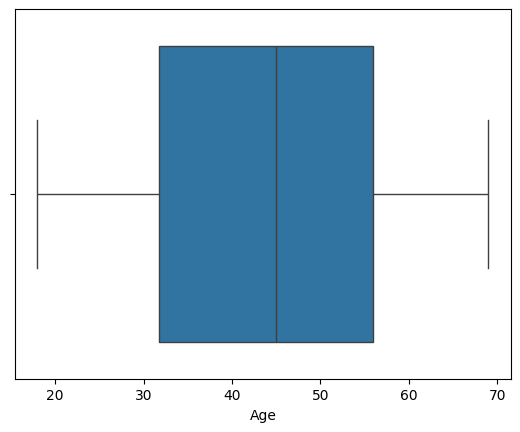

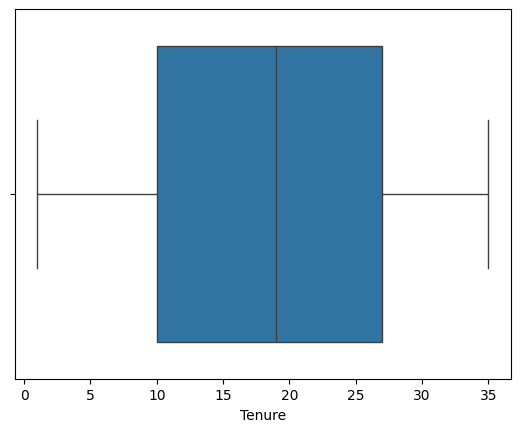

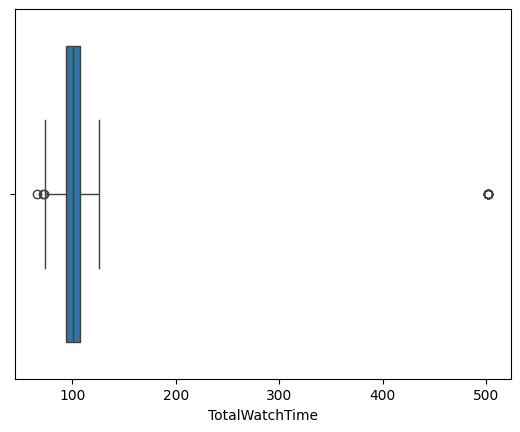

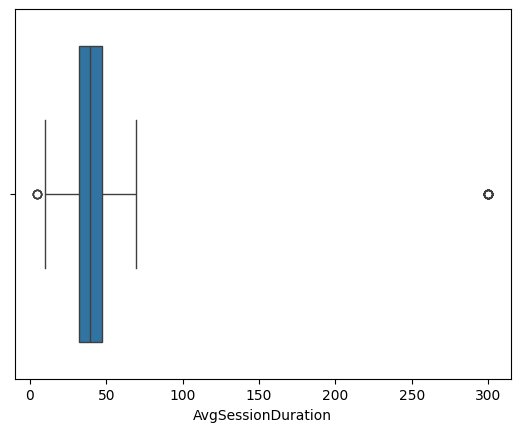

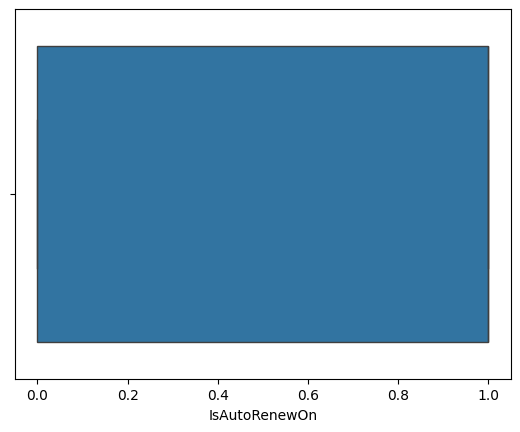

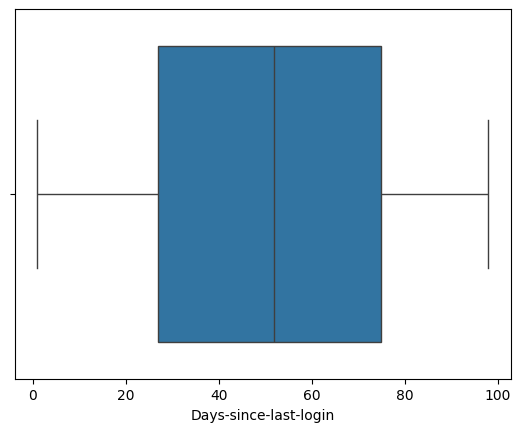

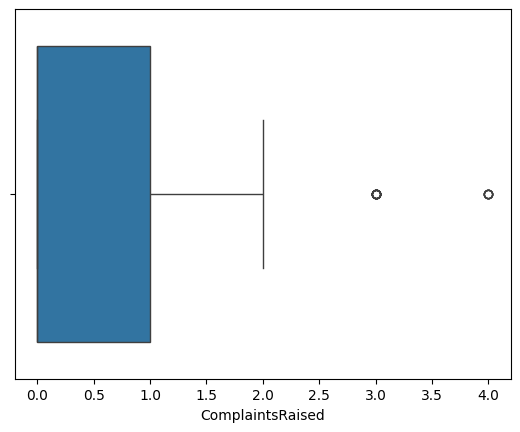

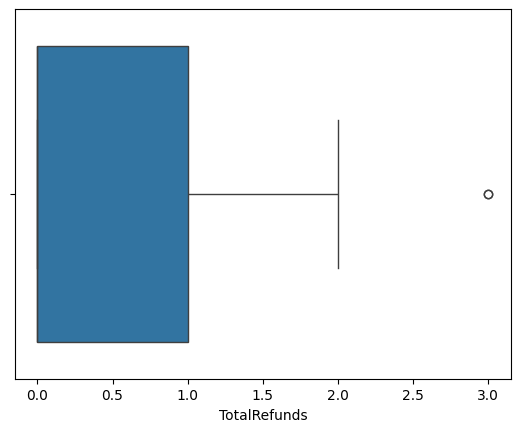

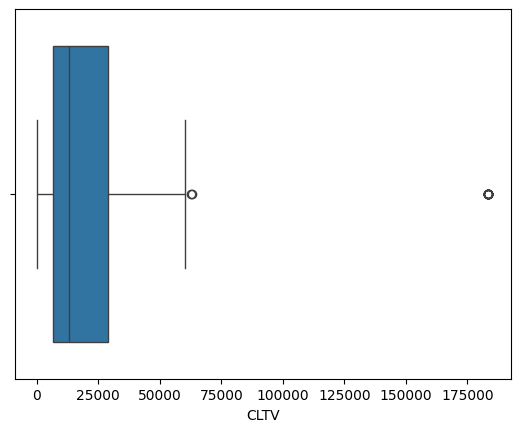

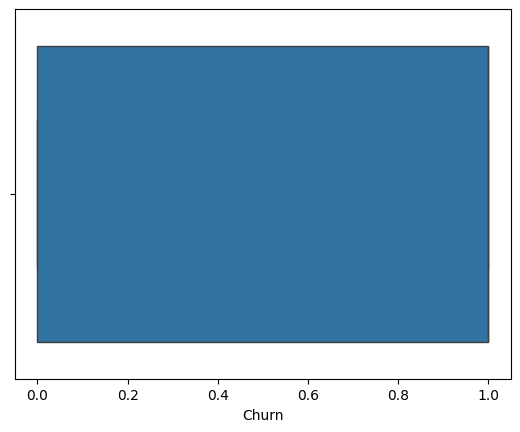

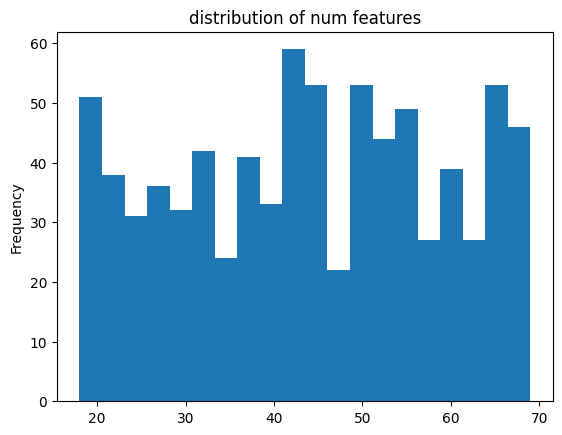

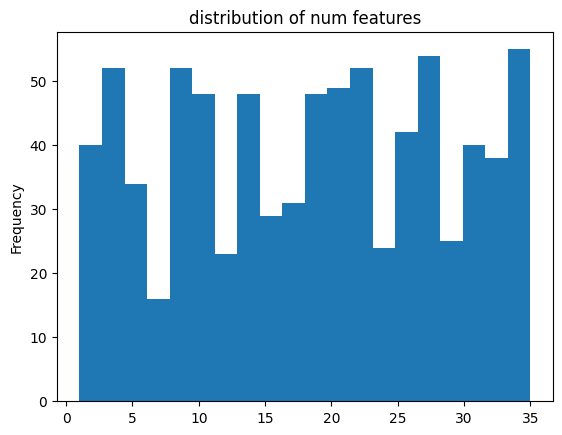

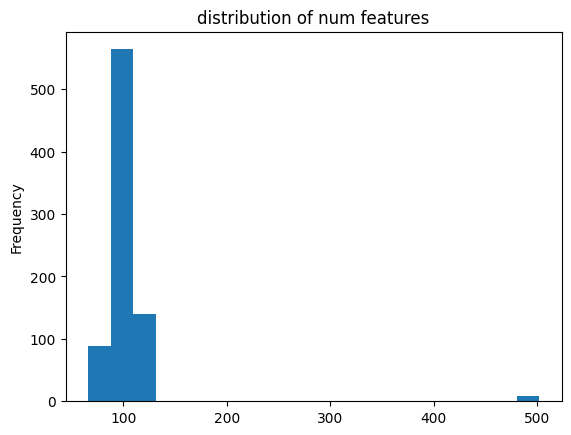

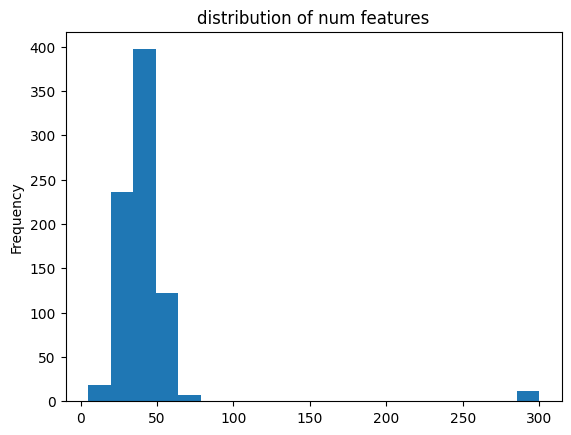

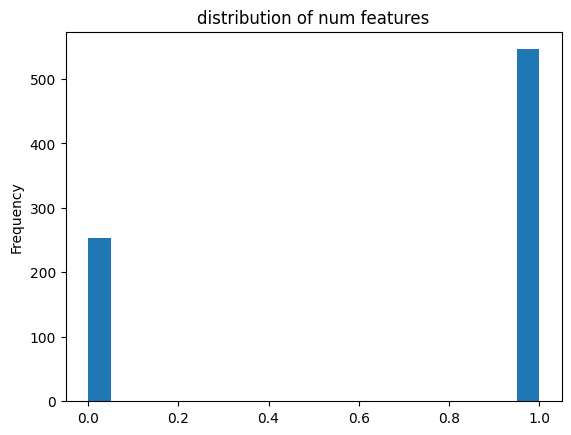

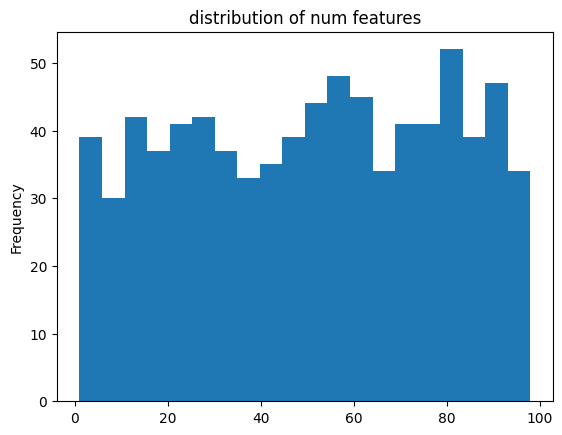

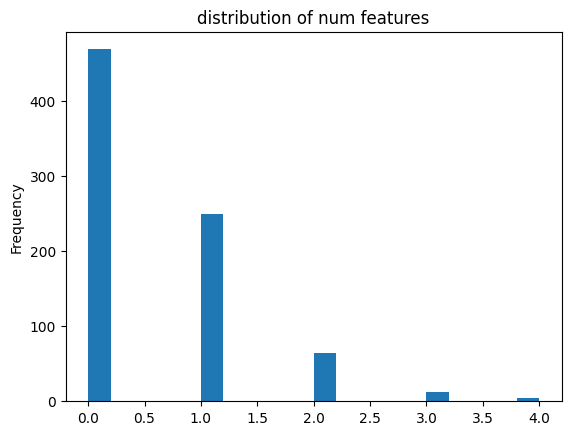

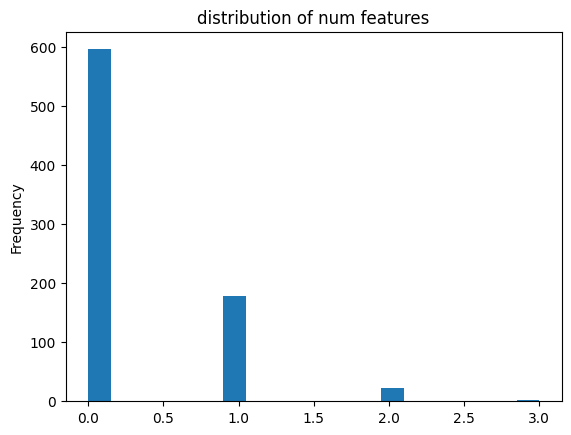

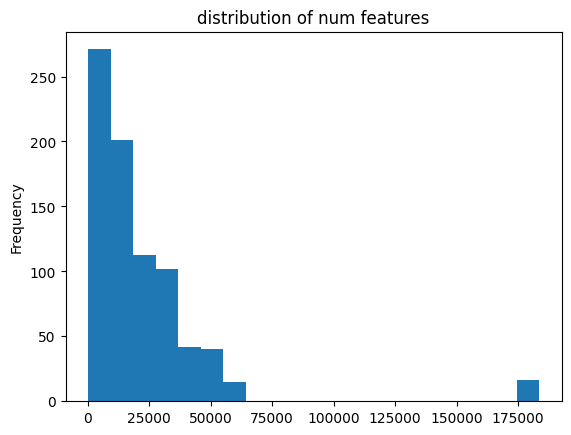

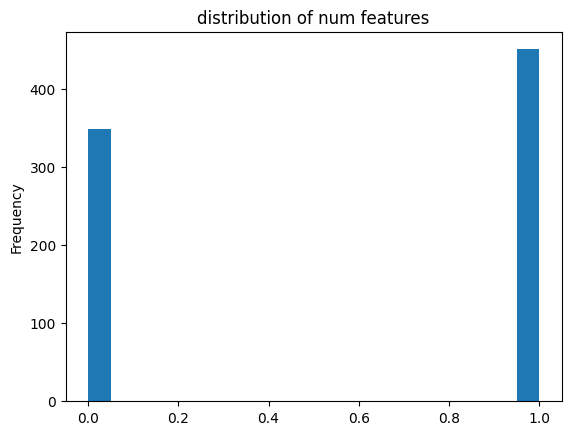

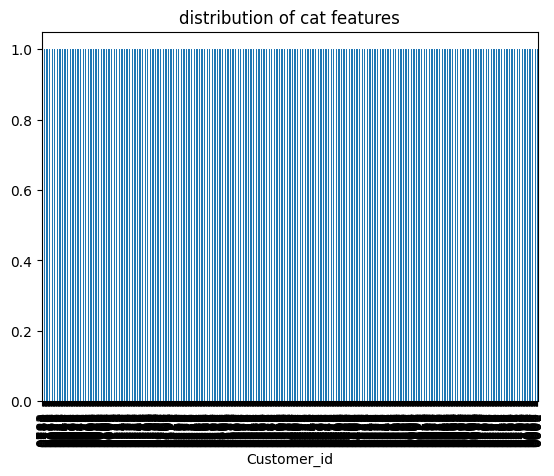

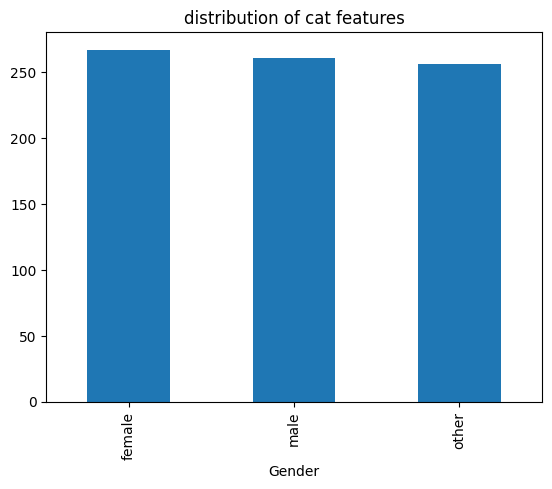

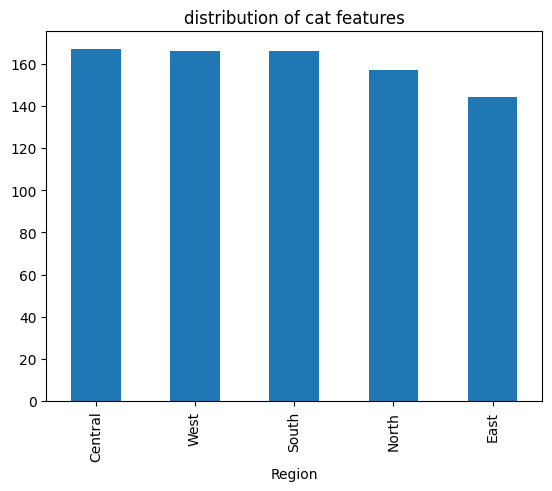

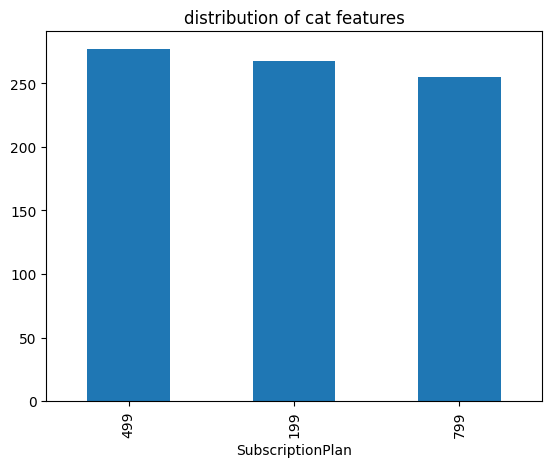

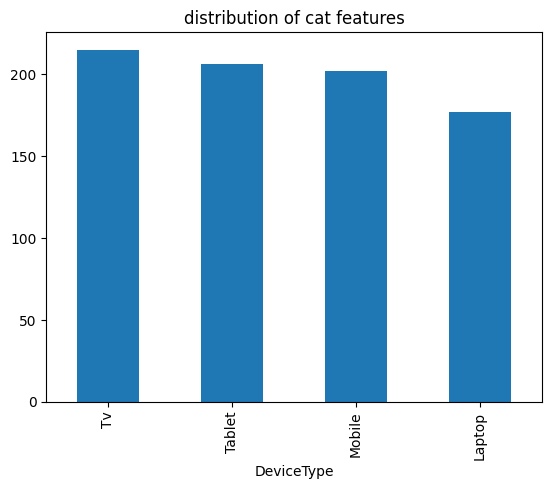

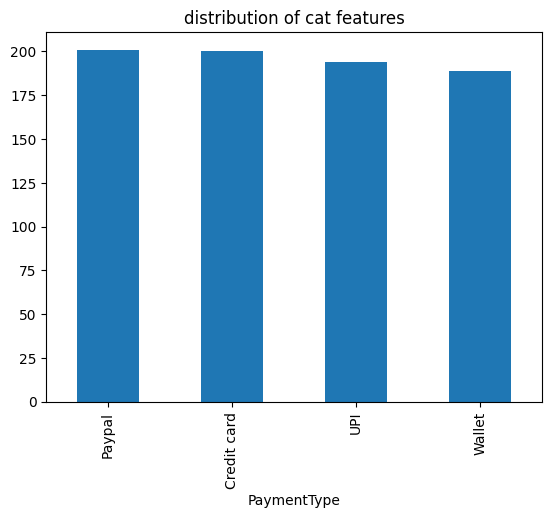

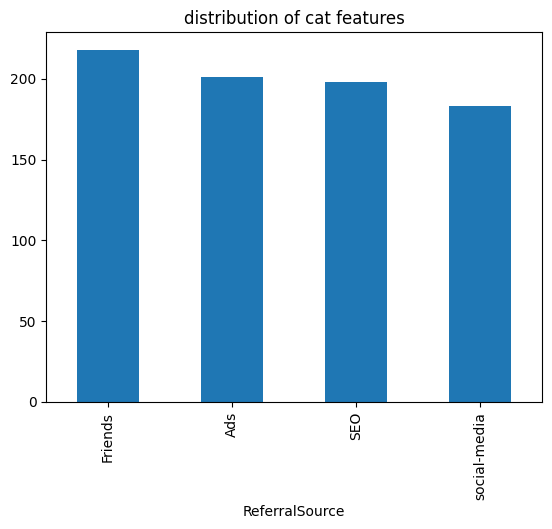

In [135]:

num_c=d.select_dtypes(include=['int64','float64']).columns.tolist()
cat_c=d.select_dtypes(include=['object']).columns.tolist()

#outlier detection
for i in num_c:
  sns.boxplot(x=d[i])
  plt.show()

#num features distribution
for i in num_c:
  d[i].plot(kind='hist',bins=20,title='distribution of num features')
  plt.show()
#cat features distribution
for c in cat_c:
  d[c].value_counts().plot(kind='bar',title='distribution of cat features')
  plt.show()



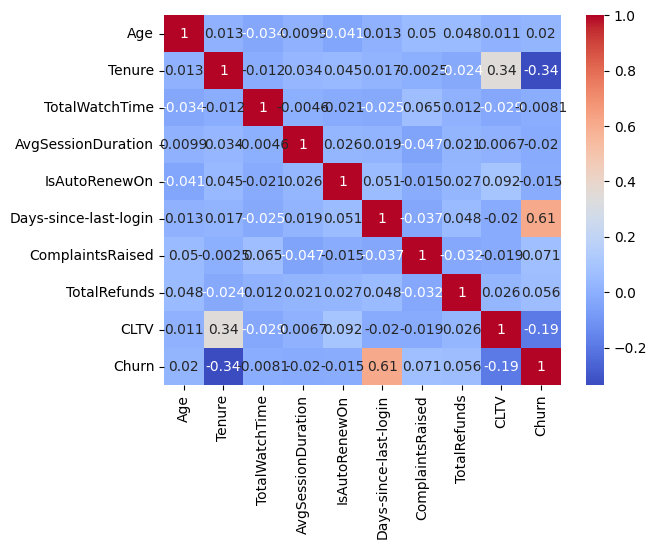

CLTV                     1.000000
Tenure                   0.343739
IsAutoRenewOn            0.092405
TotalRefunds             0.026127
Age                      0.011177
AvgSessionDuration       0.006687
ComplaintsRaised        -0.018733
Days-since-last-login   -0.019506
TotalWatchTime          -0.029403
Churn                   -0.189693
Name: CLTV, dtype: float64
Churn                    1.000000
Days-since-last-login    0.608840
ComplaintsRaised         0.071022
TotalRefunds             0.056298
Age                      0.019843
TotalWatchTime          -0.008056
IsAutoRenewOn           -0.015202
AvgSessionDuration      -0.019994
CLTV                    -0.189693
Tenure                  -0.335472
Name: Churn, dtype: float64


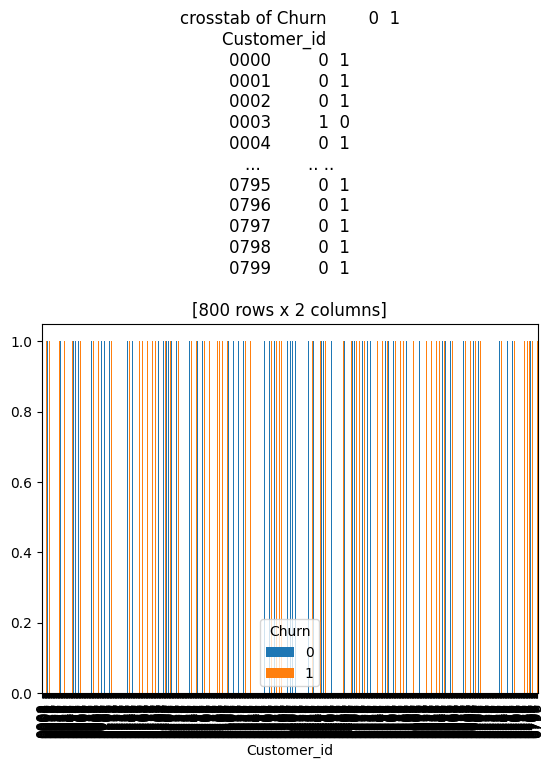

Age                     -0.062694
Tenure                  -0.043034
TotalWatchTime           9.002831
AvgSessionDuration       6.833567
IsAutoRenewOn           -0.785570
Days-since-last-login   -0.082658
ComplaintsRaised         1.535192
TotalRefunds             1.754190
CLTV                     4.230857
Churn                   -0.257582
dtype: float64
Age                      -1.117670
Tenure                   -1.166380
TotalWatchTime           84.518707
AvgSessionDuration       50.025674
IsAutoRenewOn            -1.386351
Days-since-last-login    -1.183746
ComplaintsRaised          2.703048
TotalRefunds              2.775996
CLTV                     22.200527
Churn                    -1.938504
dtype: float64


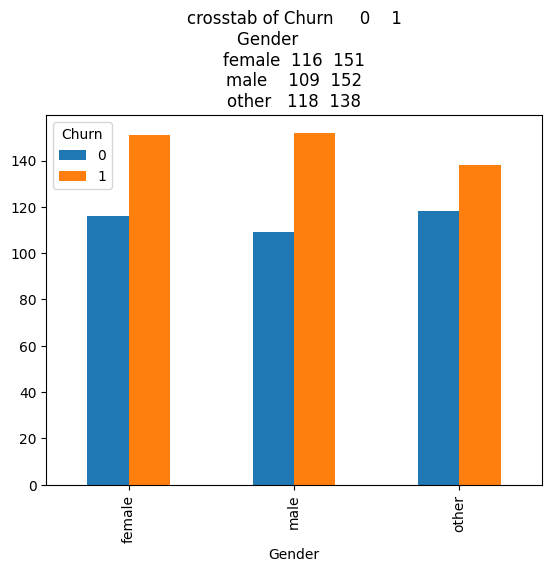

Age                     -0.062694
Tenure                  -0.043034
TotalWatchTime           9.002831
AvgSessionDuration       6.833567
IsAutoRenewOn           -0.785570
Days-since-last-login   -0.082658
ComplaintsRaised         1.535192
TotalRefunds             1.754190
CLTV                     4.230857
Churn                   -0.257582
dtype: float64
Age                      -1.117670
Tenure                   -1.166380
TotalWatchTime           84.518707
AvgSessionDuration       50.025674
IsAutoRenewOn            -1.386351
Days-since-last-login    -1.183746
ComplaintsRaised          2.703048
TotalRefunds              2.775996
CLTV                     22.200527
Churn                    -1.938504
dtype: float64


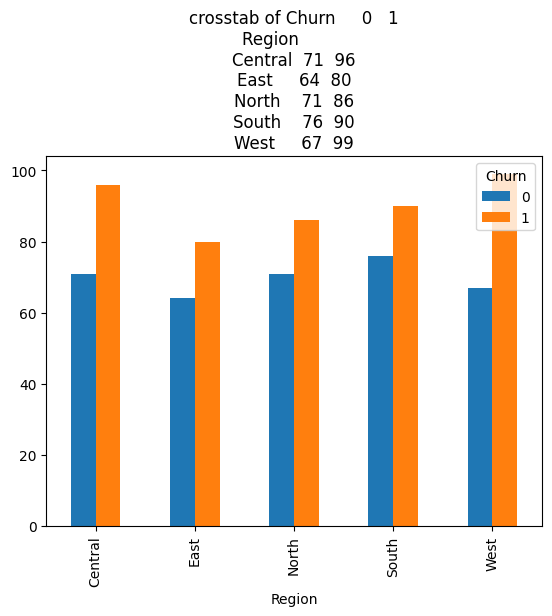

Age                     -0.062694
Tenure                  -0.043034
TotalWatchTime           9.002831
AvgSessionDuration       6.833567
IsAutoRenewOn           -0.785570
Days-since-last-login   -0.082658
ComplaintsRaised         1.535192
TotalRefunds             1.754190
CLTV                     4.230857
Churn                   -0.257582
dtype: float64
Age                      -1.117670
Tenure                   -1.166380
TotalWatchTime           84.518707
AvgSessionDuration       50.025674
IsAutoRenewOn            -1.386351
Days-since-last-login    -1.183746
ComplaintsRaised          2.703048
TotalRefunds              2.775996
CLTV                     22.200527
Churn                    -1.938504
dtype: float64


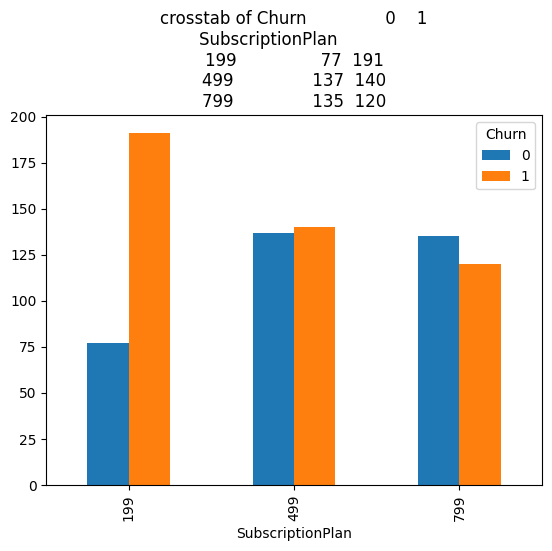

Age                     -0.062694
Tenure                  -0.043034
TotalWatchTime           9.002831
AvgSessionDuration       6.833567
IsAutoRenewOn           -0.785570
Days-since-last-login   -0.082658
ComplaintsRaised         1.535192
TotalRefunds             1.754190
CLTV                     4.230857
Churn                   -0.257582
dtype: float64
Age                      -1.117670
Tenure                   -1.166380
TotalWatchTime           84.518707
AvgSessionDuration       50.025674
IsAutoRenewOn            -1.386351
Days-since-last-login    -1.183746
ComplaintsRaised          2.703048
TotalRefunds              2.775996
CLTV                     22.200527
Churn                    -1.938504
dtype: float64


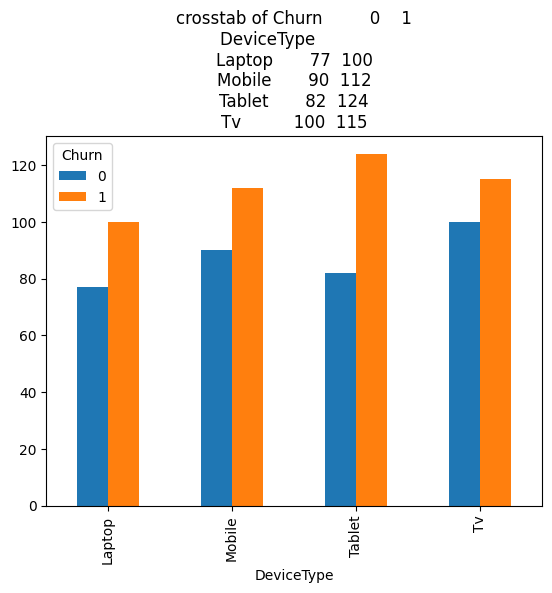

Age                     -0.062694
Tenure                  -0.043034
TotalWatchTime           9.002831
AvgSessionDuration       6.833567
IsAutoRenewOn           -0.785570
Days-since-last-login   -0.082658
ComplaintsRaised         1.535192
TotalRefunds             1.754190
CLTV                     4.230857
Churn                   -0.257582
dtype: float64
Age                      -1.117670
Tenure                   -1.166380
TotalWatchTime           84.518707
AvgSessionDuration       50.025674
IsAutoRenewOn            -1.386351
Days-since-last-login    -1.183746
ComplaintsRaised          2.703048
TotalRefunds              2.775996
CLTV                     22.200527
Churn                    -1.938504
dtype: float64


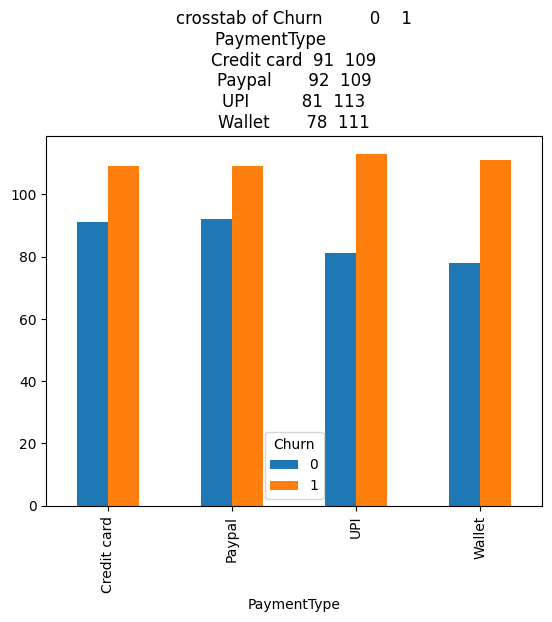

Age                     -0.062694
Tenure                  -0.043034
TotalWatchTime           9.002831
AvgSessionDuration       6.833567
IsAutoRenewOn           -0.785570
Days-since-last-login   -0.082658
ComplaintsRaised         1.535192
TotalRefunds             1.754190
CLTV                     4.230857
Churn                   -0.257582
dtype: float64
Age                      -1.117670
Tenure                   -1.166380
TotalWatchTime           84.518707
AvgSessionDuration       50.025674
IsAutoRenewOn            -1.386351
Days-since-last-login    -1.183746
ComplaintsRaised          2.703048
TotalRefunds              2.775996
CLTV                     22.200527
Churn                    -1.938504
dtype: float64


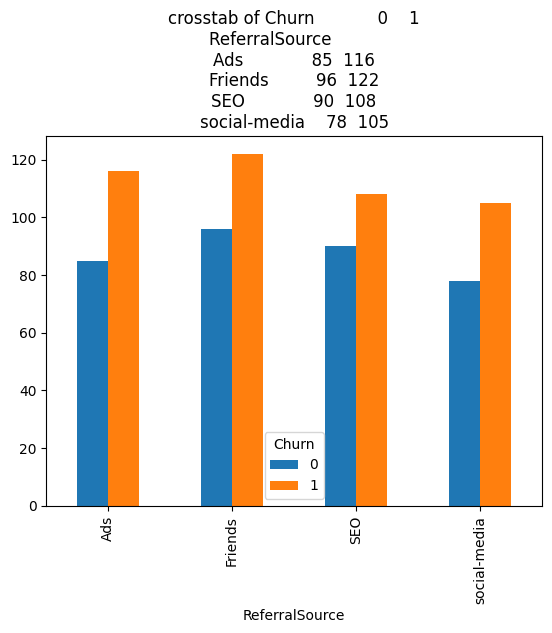

Age                     -0.062694
Tenure                  -0.043034
TotalWatchTime           9.002831
AvgSessionDuration       6.833567
IsAutoRenewOn           -0.785570
Days-since-last-login   -0.082658
ComplaintsRaised         1.535192
TotalRefunds             1.754190
CLTV                     4.230857
Churn                   -0.257582
dtype: float64
Age                      -1.117670
Tenure                   -1.166380
TotalWatchTime           84.518707
AvgSessionDuration       50.025674
IsAutoRenewOn            -1.386351
Days-since-last-login    -1.183746
ComplaintsRaised          2.703048
TotalRefunds              2.775996
CLTV                     22.200527
Churn                    -1.938504
dtype: float64


In [136]:
#correlation
corr_mat=d.corr(numeric_only=True)
sns.heatmap(corr_mat,annot=True,cmap='coolwarm')
plt.show()

#target corr
print(corr_mat['CLTV'].sort_values(ascending=False))
print(corr_mat['Churn'].sort_values(ascending=False))

#crosstab
cat_c=d.select_dtypes(include=['object']).columns.tolist()
for i in cat_c:
  ct=pd.crosstab(d[i],d['Churn'])
  ct.plot(kind='bar',title=f'crosstab of {ct}')
  plt.show()

  #skewness and kurtosis
  print(d.skew(numeric_only=True))
  print(d.kurtosis(numeric_only=True))


In [137]:
#data cleaning
#handle missing values in gender avgsessionduration,paymenttype
d['Gender']=d['Gender']=d['Gender'].fillna(d['Gender'].mode()[0])
d['AvgSessionDuration']=d['AvgSessionDuration'].fillna(d['AvgSessionDuration'].mean())
d['PaymentType']=d['PaymentType'].fillna(d['PaymentType'].mode()[0])


#handleoutliers
def cap_outliers(d,i):
  Q1=d[i].quantile(0.25)
  Q3=d[i].quantile(0.75)
  IQR=Q3-Q1
  lower_b=Q1-1.5*IQR
  upper_b=Q3+1.5*IQR
  d[i]=np.where(d[i]<lower_b,lower_b,np.where(d[i]>upper_b,upper_b,d[i]))
  return d

out_cols=['TotalWatchTime','AvgSessionDuration','ComplaintsRaised','TotalRefunds','CLTV']
for i in out_cols:
  cap_outliers(d,i)

#fix incorrect data
# Cap TotalRefunds
d['TotalRefunds']= d['TotalRefunds'].clip(0,5)

#Rename cols
d=d.rename(columns={'Days-since-last-login': 'Days_since_last-login'})

#handle duplicates
d=d.drop_duplicates()
#d=d.drop(columns=['Customer_id'])

#encode cat cols
le_gender = LabelEncoder()
le_region = LabelEncoder()
le_plan = LabelEncoder()
le_device = LabelEncoder()
le_payment = LabelEncoder()
le_referral = LabelEncoder()

d['Gender'] = le_gender.fit_transform(d['Gender'])
d['Region'] = le_region.fit_transform(d['Region'])
d['SubscriptionPlan'] = le_plan.fit_transform(d['SubscriptionPlan'])
d['DeviceType'] = le_device.fit_transform(d['DeviceType'])
d['PaymentType'] = le_payment.fit_transform(d['PaymentType'])
d['ReferralSource'] = le_referral.fit_transform(d['ReferralSource'])


#classImbalance check
print(d['CLTV'].value_counts())
print(d['Churn'].value_counts())

print(d.skew(numeric_only=True))
print(d.kurtosis(numeric_only=True))

CLTV
61806.355    18
25101.860     1
4505.180      1
17991.610     1
4922.320      1
             ..
19361.230     1
24800.380     1
8020.780      1
8020.020      1
11526.750     1
Name: count, Length: 783, dtype: int64
Churn
1    451
0    349
Name: count, dtype: int64
Age                     -0.062694
Gender                   0.062461
Region                  -0.046497
SubscriptionPlan         0.029608
Tenure                  -0.043034
TotalWatchTime           0.006559
AvgSessionDuration       0.132951
DeviceType              -0.081622
PaymentType              0.058107
ReferralSource           0.066889
IsAutoRenewOn           -0.785570
Days_since_last-login   -0.082658
ComplaintsRaised         1.078598
TotalRefunds             1.660096
CLTV                     1.000848
Churn                   -0.257582
dtype: float64
Age                     -1.117670
Gender                  -1.512587
Region                  -1.325452
SubscriptionPlan        -1.470861
Tenure                  -1.166380
T

In [236]:
#Feature engineering
#Interaction features
d['WatchTimeSession']=d['TotalWatchTime']*d['AvgSessionDuration']
d['WatchTimeComplaints']=d['ComplaintsRaised']/d['TotalWatchTime']

#Binning
d['CLTV_BIN']=pd.cut(d['CLTV'],bins=[20,40,60,80,100],labels=['Low', 'Medium', 'High', 'Very High'])

#Aggregation
d.groupby('Region').agg({
    'CLTV':['mean','max','median'],
    'TotalWatchTime': 'mean',
    'TotalRefunds': 'sum'
})

#target-encoding
region_churn_mean = d.groupby('Region')['Churn'].mean()
d['Region-TE']=d['Region'].map(region_churn_mean)

#freq or count encoding
#freq=d['SubscriptionPlan'].value_counts()
#d['SubscriptionPlan']=d['SubscriptionPlan'].map(freq)

#feature transformation
d['AvgSessionDuration']=np.log1p(d['AvgSessionDuration'])

#domain-inspired-features
d['churn-risk-score']=(
    (d['Days_since_last-login']/d['Tenure']) +
    (d['ComplaintsRaised']*2)+
    (d['TotalRefunds']*1.5)
).round(2)





In [237]:
d.columns

Index(['Customer_id', 'Age', 'Gender', 'Region', 'SubscriptionPlan', 'Tenure',
       'TotalWatchTime', 'AvgSessionDuration', 'DeviceType', 'PaymentType',
       'ReferralSource', 'IsAutoRenewOn', 'Days_since_last-login',
       'ComplaintsRaised', 'TotalRefunds', 'CLTV', 'Churn', 'churn-risk-score',
       'WatchTimeSession', 'WatchTimeComplaints', 'CLTV_BIN', 'Region-TE'],
      dtype='object')

In [238]:
#step-5 feature selection
#High-correlation
corr_m=d.corr().abs()
mask= np.triu(np.ones(corr_m.shape),k=1).astype(bool)
upper = corr_m.where(mask)
d_todrop=[col for col in upper.columns if any(upper[col]>0.85)]
d.drop(columns=d_todrop,inplace=True)
print('the dropped columns are:',d_todrop)

#low-variance
from sklearn.feature_selection import VarianceThreshold
selector=VarianceThreshold(threshold=0.01)
d_vari=selector.fit_transform(d)

selected_cols=d.columns[selector.get_support()]
d=d[selected_cols]
print('selected due to low variance:',selected_cols)

the dropped columns are: ['WatchTimeComplaints']
selected due to low variance: Index(['Customer_id', 'Age', 'Gender', 'Region', 'SubscriptionPlan', 'Tenure',
       'TotalWatchTime', 'DeviceType', 'PaymentType', 'ReferralSource',
       'IsAutoRenewOn', 'Days_since_last-login', 'ComplaintsRaised',
       'TotalRefunds', 'CLTV', 'Churn', 'churn-risk-score',
       'WatchTimeSession'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_variance_threshold.py:114: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


In [239]:
#splitting for regression
X1=d.drop('CLTV',axis=1)
Y1=d['CLTV']

#splitting for classification
X2=d.drop(['Churn','churn-risk-score'],axis=1)
Y2=d['Churn']



X1 = X1.drop(['Churn', 'churn-risk-score'], axis=1)
X2 = X2.drop(['CLTV'], axis=1)
X1 = X1.drop('Customer_id', axis=1)
X2 = X2.drop('Customer_id', axis=1)



In [240]:
print("X1 columns:", X1.columns.tolist())
print("Y1 name:", Y1.name)

print("X2 columns:", X2.columns.tolist())
print("Y2 name:", Y2.name)


X1 columns: ['Age', 'Gender', 'Region', 'SubscriptionPlan', 'Tenure', 'TotalWatchTime', 'DeviceType', 'PaymentType', 'ReferralSource', 'IsAutoRenewOn', 'Days_since_last-login', 'ComplaintsRaised', 'TotalRefunds', 'WatchTimeSession']
Y1 name: CLTV
X2 columns: ['Age', 'Gender', 'Region', 'SubscriptionPlan', 'Tenure', 'TotalWatchTime', 'DeviceType', 'PaymentType', 'ReferralSource', 'IsAutoRenewOn', 'Days_since_last-login', 'ComplaintsRaised', 'TotalRefunds', 'WatchTimeSession']
Y2 name: Churn


Selected features for reg: ['Gender', 'SubscriptionPlan', 'Tenure', 'TotalWatchTime', 'AvgSessionDuration', 'DeviceType', 'PaymentType', 'ReferralSource', 'IsAutoRenewOn', 'TotalRefunds']
Selected features for classi: Index(['Age', 'Gender', 'SubscriptionPlan', 'Tenure', 'TotalWatchTime',
       'AvgSessionDuration', 'DeviceType', 'PaymentType', 'IsAutoRenewOn',
       'Days_since_last-login', 'ComplaintsRaised', 'TotalRefunds'],
      dtype='object')
RFE Selected Features for r: ['Gender', 'SubscriptionPlan', 'Tenure', 'TotalWatchTime', 'AvgSessionDuration', 'DeviceType', 'PaymentType', 'ReferralSource', 'IsAutoRenewOn', 'TotalRefunds']
Rfe selected Features for c: Index(['Age', 'Gender', 'SubscriptionPlan', 'Tenure', 'TotalWatchTime',
       'AvgSessionDuration', 'DeviceType', 'PaymentType', 'IsAutoRenewOn',
       'Days_since_last-login', 'ComplaintsRaised', 'TotalRefunds'],
      dtype='object')


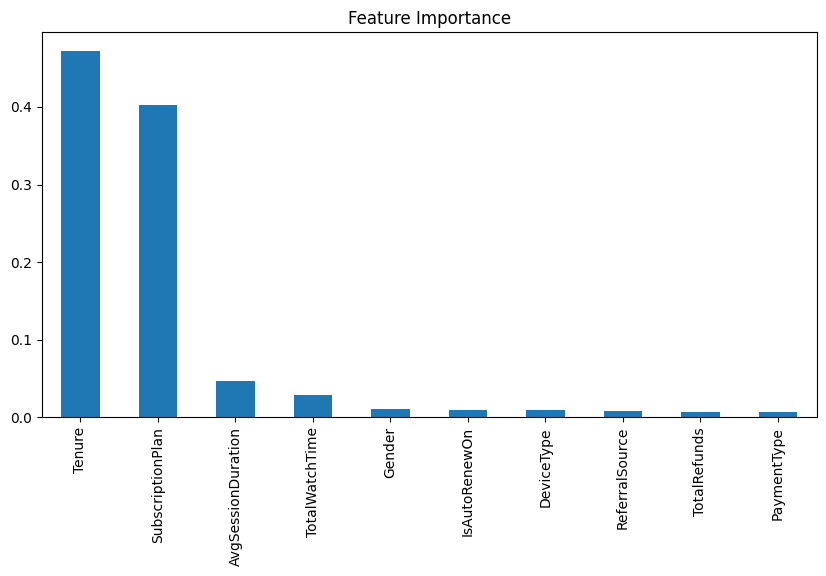

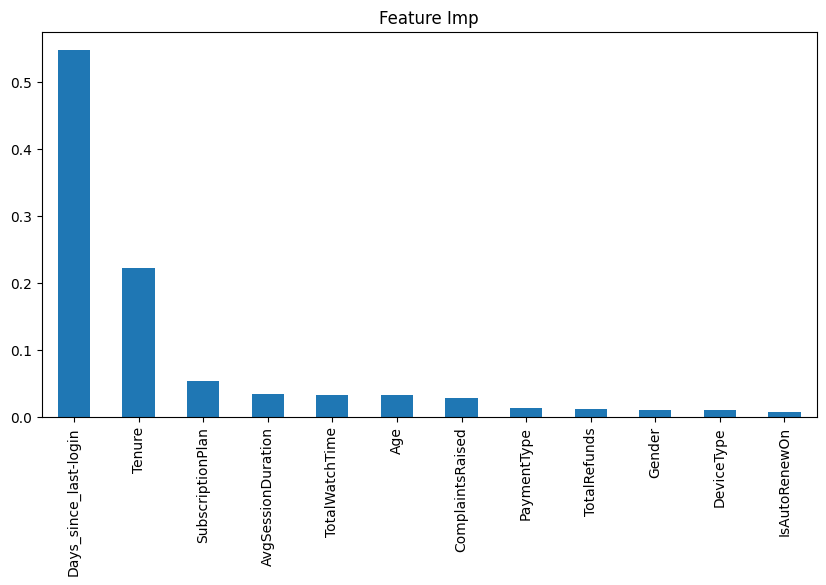

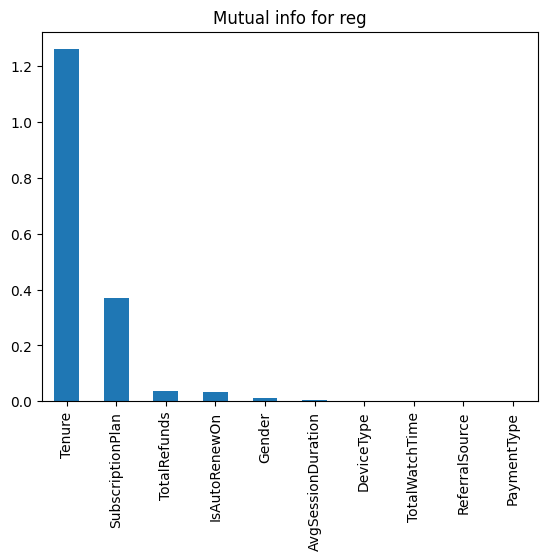

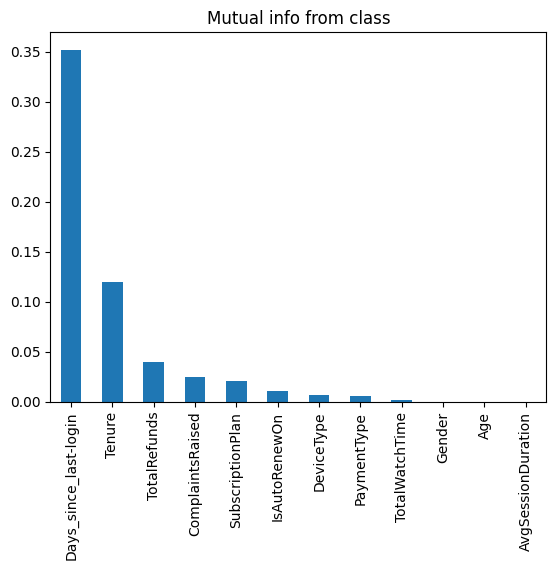

In [212]:
#univariate feature selection
from sklearn.feature_selection import SelectKBest,f_classif,f_regression
#for regression
selector_r=SelectKBest(score_func=f_regression,k=10)
selector_r.fit(X1,Y1)
selected_features_r=X1.columns[selector_r.get_support()]
X1=X1[selected_features_r]
print('Selected features for reg:',selected_features_r.tolist())


#for classification
selector_c= SelectKBest(score_func=f_classif,k=12)
selector_c.fit(X2,Y2)
selected_features_c=X2.columns[selector_c.get_support()]
X2=X2[selected_features_c]
print('Selected features for classi:',selected_features_c)


#RFE
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier

#for reg
rfe_sel_r=RFE(estimator=RandomForestRegressor(),n_features_to_select=10)
X1_rfe=rfe_sel_r.fit_transform(X1,Y1)
rfe_selected_r=X1.columns[rfe_sel_r.get_support()]
X1=X1[rfe_selected_r]
print('RFE Selected Features for r:',rfe_selected_r.tolist())

#for classi
rfe_sel_c=RFE(estimator=RandomForestClassifier(),n_features_to_select=12)
X2_rfe= rfe_sel_c.fit_transform(X2,Y2)
rfe_selected_c=X2.columns[rfe_sel_c.get_support()]
X2=X2[rfe_selected_c]
print('Rfe selected Features for c:',rfe_selected_c)


#Feature Importance for tree based
#for reg
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
model1=RandomForestRegressor()
model1.fit(X1,Y1)
feat_imp1=pd.Series(model1.feature_importances_,index=X1.columns)
feat_imp1.sort_values(ascending=False).plot(kind='bar',figsize=(10,5),title='Feature Importance')
plt.show()

#for classi
from sklearn.ensemble import RandomForestClassifier
model2=RandomForestClassifier()
model2.fit(X2,Y2)
feat_imp2=pd.Series(model2.feature_importances_,index=X2.columns)
feat_imp2.sort_values(ascending=False).plot(kind='bar',figsize=(10,5),title='Feature Imp')
plt.show()

#Mutual Info
from sklearn.feature_selection import mutual_info_regression,mutual_info_classif
#reg
mi_score_r=mutual_info_regression(X1,Y1)
mi_d1= pd.Series(mi_score_r,index=X1.columns).sort_values(ascending=False)
mi_d1.plot(kind='bar',title='Mutual info for reg')
plt.show()
#classi
mi_score_c=mutual_info_classif(X2,Y2)
mi_d2=pd.Series(mi_score_c,index=X2.columns).sort_values(ascending=False)
mi_d2.plot(kind='bar',title='Mutual info from class')
plt.show()


#5.7 – Final Feature Set
x1_selected_r = X1.copy()  # Keep only selected features here for reg
x2_selected_c = X2.copy()


In [213]:
# Safe dynamic detection of present categorical columns
possible_cats = ['Gender', 'Region', 'SubscriptionPlan', 'DeviceType', 'PaymentType', 'ReferralSource']

# For regression
categorical_cols_r = [col for col in possible_cats if col in x_train_r.columns]
numerical_cols_r = [col for col in x_train_r.columns if col not in categorical_cols_r]

# For classification
categorical_cols_c = [col for col in possible_cats if col in x_train_c.columns]
numerical_cols_c = [col for col in x_train_c.columns if col not in categorical_cols_c]


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# For regression
preprocessor_r = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols_r),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_r)
])

# For classification
preprocessor_c = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols_c),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_c)
])


In [214]:
print(x_train_r.columns.tolist())
print(x_train_c.columns.tolist())


['Gender', 'SubscriptionPlan', 'Tenure', 'TotalWatchTime', 'AvgSessionDuration', 'DeviceType', 'PaymentType', 'ReferralSource', 'IsAutoRenewOn', 'TotalRefunds']
['Age', 'Gender', 'SubscriptionPlan', 'Tenure', 'TotalWatchTime', 'AvgSessionDuration', 'DeviceType', 'PaymentType', 'IsAutoRenewOn', 'Days_since_last-login', 'ComplaintsRaised', 'TotalRefunds']


In [241]:
#model for reg
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

models_r = {
    'LinearRegression': LinearRegression(),
    'RidgeRegression': Ridge(alpha=1.0),
    'LassoRegression': Lasso(alpha=0.1),
    'RandomForest': RandomForestRegressor(random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'KNN': KNeighborsRegressor(),
    'SVR': SVR(),
    'XGBoost': XGBRegressor(eval_metric='rmse'),
    'ANN': MLPRegressor(hidden_layer_sizes=(100,), max_iter=300, early_stopping=True)
}



#model for classi
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

models_c = {
    'LogisticRegression': LogisticRegression(max_iter=3000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'NaiveBayes': GaussianNB(),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    'ANN': MLPClassifier(hidden_layer_sizes=(100,), max_iter=300,early_stopping=True,random_state=42)

}

In [247]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

best_model_r = None
best_score_r = -np.inf
metrics_r = []

for name, model in models_r.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor_r),
        ('regressor', model)
    ])

    pipe.fit(x_train_r, y_train_r)
    y_pred = pipe.predict(x_test_r)

    r2 = r2_score(y_test_r, y_pred)
    mae = mean_absolute_error(y_test_r, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_r, y_pred))

    metrics_r.append({'Model': name, 'R2': r2, 'MAE': mae, 'RMSE': rmse})

    if r2 > best_score_r:
        best_score_r = r2
        best_model_r = pipe
        best_model_name_r = name


# Convert to DataFrame for comparison
results_r = pd.DataFrame(metrics_r).sort_values(by='R2', ascending=False)
print("📊 Regression Results:\n", results_r)



#classification

from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE

best_model_c = None
best_score_c = 0
metrics_c = []

for name, model in models_c.items():
    pipe_c = Pipeline([
        ('preprocessor', preprocessor_c),
        ('smote', SMOTE(random_state=42)),  # ✅ Will now work
        ('classifier', model)
    ])

    pipe_c.fit(x_train_c, y_train_c)
    y_pred = pipe_c.predict(x_test_c)
    y_prob = pipe_c.predict_proba(x_test_c)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test_c, y_pred)
    prec = precision_score(y_test_c, y_pred, zero_division=0)
    rec = recall_score(y_test_c, y_pred)
    f1 = f1_score(y_test_c, y_pred)
    roc = roc_auc_score(y_test_c, y_prob) if y_prob is not None else None

    metrics_c.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC AUC': roc
    })

    if f1 > best_score_c:
        best_score_c = f1
        best_model_c = pipe_c  # ✅ fix: previously was `pipe` (regression model)
        best_model_name_c = name

# Display results
results_c = pd.DataFrame(metrics_c).sort_values(by='F1 Score', ascending=False)
print("📊 Classification Results:\n", results_c)


📊 Regression Results:
               Model        R2           MAE          RMSE
3      RandomForest  0.657182   3316.260062   8710.553915
1   RidgeRegression  0.632502   5039.880912   9018.647602
0  LinearRegression  0.632318   5045.056626   9020.910902
2   LassoRegression  0.632315   5045.030068   9020.938919
7           XGBoost  0.631540   3435.421873   9030.450935
5               KNN  0.520208   6613.535806  10304.825883
4      DecisionTree  0.249702   4400.860656  12886.377171
6               SVR -0.121798  10896.893619  15756.919292
8               ANN -1.542159  18474.769534  23720.036434


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:41:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Classification Results:
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
1        RandomForest  0.977901   1.000000  0.956989  0.978022  0.999695
2        DecisionTree  0.972376   0.988889  0.956989  0.972678  0.972813
6             XGBoost  0.972376   0.988889  0.956989  0.972678  0.991691
4                 SVM  0.878453   0.865979  0.903226  0.884211  0.968597
7                 ANN  0.817680   0.826087  0.817204  0.821622  0.897239
0  LogisticRegression  0.806630   0.815217  0.806452  0.810811  0.909702
3                 KNN  0.784530   0.821429  0.741935  0.779661  0.865775
5          NaiveBayes  0.513812   0.513812  1.000000  0.678832  0.500000


In [250]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Step 1: Define known possible categorical columns
possible_categorical_columns = ['Gender', 'Region', 'SubscriptionPlan', 'DeviceType', 'PaymentType', 'ReferralSource']

# Step 2: Get actual columns from your data
current_columns = X2.columns.tolist()  # Or x_train_c.columns if already split

# Step 3: Filter columns based on what exists now
categorical_cols_c = [col for col in possible_categorical_columns if col in current_columns]
numerical_cols_c = [col for col in current_columns if col not in categorical_cols_c]

# Step 4: Create safe and updated ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor_c = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols_c),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_c)
])


In [256]:
# Suppose x_train_c is your final training features DataFrame after feature selection for classification
possible_cats = ['Gender', 'Region', 'SubscriptionPlan', 'DeviceType', 'PaymentType', 'ReferralSource']

categorical_cols_c = [col for col in possible_cats if col in x_train_c.columns]
numerical_cols_c = [col for col in x_train_c.columns if col not in categorical_cols_c]

# Similarly for regression
categorical_cols_r = [col for col in possible_cats if col in x_train_r.columns]
numerical_cols_r = [col for col in x_train_r.columns if col not in categorical_cols_r]


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor_c = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols_c),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_c)
])

preprocessor_r = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols_r),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_r)
])



pipe_c = Pipeline([
    ('preprocessor', preprocessor_c),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])


In [261]:
#Hyperparameter for reg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define param grid
param_dist_r = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'subsample': uniform(0.6, 0.4)
}

gbr_random = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=param_dist_r,
    n_iter=30,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

gbr_random.fit(x_train_r, y_train_r)

print("✅ Best GBR Parameters:", gbr_random.best_params_)
print("📈 Best GBR R² Score:", gbr_random.best_score_)

best_gbr_model = gbr_random.best_estimator_








#hyperparameter for classi
from xgboost import XGBClassifier

param_dist_xgb = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

xgb_random = RandomizedSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_distributions=param_dist_xgb,
    n_iter=30,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

xgb_random.fit(x_train_c, y_train_c)

print("✅ Best XGB Parameters:", xgb_random.best_params_)
print("📈 Best XGB F1 Score:", xgb_random.best_score_)

best_xgb_model = xgb_random.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits
✅ Best GBR Parameters: {'learning_rate': np.float64(0.0330939729486379), 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 127, 'subsample': np.float64(0.9718790609370292)}
📈 Best GBR R² Score: 0.843911857385194
Fitting 5 folds for each of 30 candidates, totalling 150 fits
✅ Best XGB Parameters: {'colsample_bytree': np.float64(0.7579526072702278), 'learning_rate': np.float64(0.09804645241541143), 'max_depth': 9, 'n_estimators': 238, 'subsample': np.float64(0.679536961635522)}
📈 Best XGB F1 Score: 0.9859936005126295


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:56:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [265]:
#for reg
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_pred_reg = best_gbr_model.predict(x_test_r)

print("R² Score :", r2_score(y_test_r, y_pred_reg))
print("MAE      :", mean_absolute_error(y_test_r, y_pred_reg))
print("MSE      :", mean_squared_error(y_test_r, y_pred_reg))
print("RMSE     :", np.sqrt(mean_squared_error(y_test_r, y_pred_reg)))

#for classi
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

y_pred_clf = best_xgb_model.predict(x_test_c)

print("Accuracy :", accuracy_score(y_test_c, y_pred_clf))
print("Precision:", precision_score(y_test_c, y_pred_clf))
print("Recall   :", recall_score(y_test_c, y_pred_clf))
print("F1 Score :", f1_score(y_test_c, y_pred_clf))
print("ROC-AUC  :", roc_auc_score(y_test_c, y_pred_clf))
print("Confusion Matrix:\n", confusion_matrix(y_test_c, y_pred_clf))


R² Score : 0.7059396430219842
MAE      : 3075.997003975679
MSE      : 65082531.62160764
RMSE     : 8067.374518491604
Accuracy : 0.9779005524861878
Precision: 1.0
Recall   : 0.956989247311828
F1 Score : 0.978021978021978
ROC-AUC  : 0.978494623655914
Confusion Matrix:
 [[88  0]
 [ 4 89]]


In [266]:
# Example customer input
new_customer = {
    'Age': 35,
    'Gender': 'male',
    'Region': 'south',
    'SubscriptionPlan': 'premium',
    'Tenure': 12,
    'TotalWatchTime': 120.5,
    'AvgSessionDuration': 45.2,
    'DeviceType': 'mobile',
    'PaymentType': 'credit_card',
    'ReferralSource': 'social_media',
    'IsAutoRenewOn': 1,
    'Days_since_last-login': 2,
    'ComplaintsRaised': 0,
    'TotalRefunds': 100.0
}

new_data = pd.DataFrame([new_customer])
cltv_prediction = best_model_r.predict(new_data)[0]
print(f"Predicted CLTV: ₹{cltv_prediction:.2f}")

churn_prediction = best_model_c.predict(new_data)[0]
churn_probability = best_model_c.predict_proba(new_data)[0][1]
print("Churn Prediction:", "Yes" if churn_prediction == 1 else "No")
print(f"Churn Probability: {churn_probability:.2%}")


Predicted CLTV: ₹29252.92
Churn Prediction: Yes
Churn Probability: 88.00%


In [267]:
for i in range(5):
    sample = x2_selected_c.sample(1, random_state=i)
    prob = best_model_c.predict_proba(sample)[0][1]
    print(f"Churn probability for sample {i}: {prob:.2%}")


Churn probability for sample 0: 83.00%
Churn probability for sample 1: 81.00%
Churn probability for sample 2: 82.00%
Churn probability for sample 3: 82.00%
Churn probability for sample 4: 83.00%
